First step is to read the scraped data, clean the data and prepare it for the model.

**before running the code, create a python virtual environment within the model folder:**

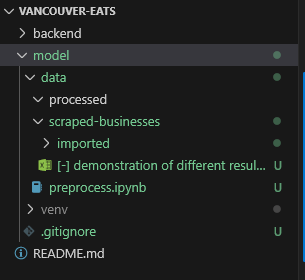

make sure you install the appropriate libraries:

```pip install numpy pandas matplotlib```

Importing libraries below:

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import re

In [4]:
import os

# Read all CSV files in the 'imported' folder
folder_path = 'scraped-businesses/imported'
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Concatenate all CSV files into a single DataFrame
raw_data = pd.concat([pd.read_csv(os.path.join(folder_path, file)) for file in csv_files])

In [5]:
raw_data.head()

,input_id,link,title,category,address,open_hours,popular_times,website,phone,plus_code,...,data_id,images,reservations,order_online,menu,owner,complete_address,about,user_reviews,emails
0,6623c9e0-0a30-4aab-b666-353f1681fa0f,https://www.google.com/maps/place/Little+Cocka...,Little Cockatoo Cafe,Restaurant,"7548 Edmonds St, Burnaby, BC V3N 1B5","{""Friday"":[""11 a.m.–2 p.m."",""4–10 p.m.""],""Mond...",{},NaN,(604) 540-1715,"63C4+XG Burnaby, British Columbia",...,0x548677c63f166111:0x1883fee644a6e217,"[{""title"":""All"",""image"":""https://lh5.googleuse...",NaN,NaN,"{""link"":"""",""source"":""""}","{""id"":"""",""name"":""Little Cockatoo Cafe (Owner)""...","{""borough"":"""",""street"":""7548 Edmonds St"",""city...","[{""id"":""service_options"",""name"":""Service optio...","[{""Name"":""Whitney Bee"",""ProfilePicture"":""https...",NaN
1,6623c9e0-0a30-4aab-b666-353f1681fa0f,https://www.google.com/maps/place/Peaceful+res...,Peaceful restaurant,Chinese restaurant,"7355 Edmonds St, Burnaby, BC V3N 1A9","{""Friday"":[""11 a.m.–3 p.m."",""4–9 p.m.""],""Monda...",{},https://peacefulrestaurantburnaby.zomi.menu/,(236) 453-2002,"629X+QX Burnaby, British Columbia",...,0x548677f1e3cd4109:0x75a643b49f4d0f4c,"[{""title"":""All"",""image"":""https://lh5.googleuse...",NaN,NaN,"{""link"":""https://www.peacefulrestaurant.com/"",...","{""id"":""115340420184533789285"",""name"":""Peaceful...","{""borough"":"""",""street"":""7355 Edmonds St"",""city...","[{""id"":""service_options"",""name"":""Service optio...","[{""Name"":""Kathy Lok"",""ProfilePicture"":""https:/...",NaN
2,6623c9e0-0a30-4aab-b666-353f1681fa0f,https://www.google.com/maps/place/Balkan+House...,Balkan House Restaurant,Eastern European restaurant,"7530 Edmonds St, Burnaby, BC V3N 1B4","{""Friday"":[""11 a.m.–2 p.m."",""4–10 p.m.""],""Mond...","{""Friday"":{""10"":0,""11"":2,""12"":10,""13"":7,""14"":0...",http://balkanhouse.info/,(604) 524-0404,"63C4+V8 Burnaby, British Columbia",...,0x548677c63d1c7293:0x457de6980e085ea9,"[{""title"":""All"",""image"":""https://lh5.googleuse...",NaN,NaN,"{""link"":""http://balkanhouse.info/?page_id=30"",...","{""id"":""116234276162211849798"",""name"":""Balkan H...","{""borough"":"""",""street"":""7530 Edmonds St"",""city...","[{""id"":""service_options"",""name"":""Service optio...","[{""Name"":""Cheryl Chan"",""ProfilePicture"":""https...",NaN
3,6623c9e0-0a30-4aab-b666-353f1681fa0f,https://www.google.com/maps/place/Sushi+On+Bur...,Sushi On Burnaby (Edmonds st),Japanese restaurant,"7617 Edmonds St, Burnaby, BC V3N 1B6","{""Friday"":[""11:30 a.m.–10 p.m.""],""Monday"":[""11...","{""Friday"":{""10"":0,""11"":19,""12"":34,""13"":38,""14""...",https://sushion.ca/,(604) 521-1550,"63F4+8P Burnaby, British Columbia",...,0x548677aa8aa95091:0xb4357ce5a3060d53,"[{""title"":""All"",""image"":""https://lh5.googleuse...",NaN,NaN,"{""link"":""https://turnthesushion.com/"",""source""...","{""id"":""113706474279015267125"",""name"":""Sushi On...","{""borough"":"""",""street"":""7617 Edmonds St"",""city...","[{""id"":""service_options"",""name"":""Service optio...","[{""Name"":""Karen Calitis"",""ProfilePicture"":""htt...",NaN
4,6623c9e0-0a30-4aab-b666-353f1681fa0f,https://www.google.com/maps/place/Mineiros+Bra...,Mineiros Brazilian Bistro,Restaurant,"7542 Edmonds St, Burnaby, BC V3N 1B4","{""Friday"":[""9 a.m.–9 p.m.""],""Monday"":[""10 a.m....","{""Friday"":{""10"":24,""11"":44,""12"":42,""13"":42,""14...",https://instagram.com/mineirosbrazilian?igshid...,(236) 867-5620,"63C4+WC Burnaby, British Columbia",...,0x548677af8576dcff:0xf45db0143e0c59e3,"[{""title"":""All"",""image"":""https://lh5.googleuse...",NaN,NaN,"{""link"":"""",""source"":""""}","{""id"":""112260977254540693735"",""name"":""Mineiros...","{""borough"":"""",""street"":""7542 Edmonds St"",""city...","[{""id"":""service_options"",""name"":""Service optio...","[{""Name"":""Maria M"",""ProfilePicture"":""https://l...",NaN


In [35]:
# check number of duplicate entries based on name and address
# Remove duplicate entries based on 'title' and 'address'
raw_data = raw_data.drop_duplicates(subset=['title', 'address'])
raw_data.shape


(5942, 32)

In [36]:
raw_data.columns.tolist()

# Add relevant columns to new DataFrame
data_columns = ['title', 'category', 'address', 'open_hours', 'website', 'phone', 'review_count',
 'review_rating',
 'reviews_per_rating',
 'latitude',
 'longitude', 'descriptions', 'price_range', 'reservations',
 'order_online', 'menu', 'about',
 'user_reviews']
data = raw_data[data_columns]

# Convert 'menu' from JSON string to dict, then extract 'link'
data['menu'] = data['menu'].apply(lambda x: json.loads(x)['link'] if pd.notnull(x) and x.strip() else None)
data['menu'] = data['menu'].replace('', np.nan)

# Expand 'open_hours' JSON into separate columns for each day of the week
open_hours_expanded = data['open_hours'].apply(lambda x: json.loads(x) if pd.notnull(x) and x.strip() else {})
open_hours_df = pd.json_normalize(open_hours_expanded)

# Add the expanded columns to the data DataFrame, prefixing with 'hours_'
open_hours_df = open_hours_df.add_prefix('hours_')

# Remove any columns from open_hours_df that already exist in data to avoid duplicate columns
data = data.drop(columns=['open_hours'])

data.index = range(len(data))
data = pd.concat([data, open_hours_df], axis=1)

# split price range into lower and upper bounds

def parse_price_range(price_range):
    if pd.isna(price_range):
        return (np.nan, np.nan)
    s = str(price_range)
    # Extract all numbers (works for –, -, CA$, spaces, etc.)
    nums = re.findall(r'\d+', s)
    if len(nums) == 1:
        val = float(nums[0])
        return (val, val)
    if len(nums) >= 2:
        return (float(nums[0]), float(nums[1]))
    return (np.nan, np.nan)

data[['price_lower', 'price_upper']] = pd.DataFrame(
    data['price_range'].apply(parse_price_range).tolist(),
    index=data.index
)
data = data.drop(columns=['price_range'])

# Display the first few rows with up to 30 columns for easier viewing
pd.set_option('display.max_columns', 30)
display(data.head())
data.head()

C:\Users\leran\AppData\Local\Temp\ipykernel_35584\3841821015.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['menu'] = data['menu'].apply(lambda x: json.loads(x)['link'] if pd.notnull(x) and x.strip() else None)
C:\Users\leran\AppData\Local\Temp\ipykernel_35584\3841821015.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['menu'] = data['menu'].replace('', np.nan)


,title,category,address,website,phone,review_count,review_rating,reviews_per_rating,latitude,longitude,descriptions,reservations,order_online,menu,about,user_reviews,hours_Friday,hours_Monday,hours_Saturday,hours_Sunday,hours_Thursday,hours_Tuesday,hours_Wednesday,price_lower,price_upper
0,Little Cockatoo Cafe,Restaurant,"7548 Edmonds St, Burnaby, BC V3N 1B5",NaN,(604) 540-1715,42,4.7,"{""1"":1,""2"":0,""3"":4,""4"":2,""5"":35}",49.222406,-122.943743,NaN,NaN,NaN,NaN,"[{""id"":""service_options"",""name"":""Service optio...","[{""Name"":""Whitney Bee"",""ProfilePicture"":""https...","[11 a.m.–2 p.m., 4–10 p.m.]","[11 a.m.–2 p.m., 4–10 p.m.]",[11 a.m.–10 p.m.],[11 a.m.–10 p.m.],"[11 a.m.–2 p.m., 4–10 p.m.]","[11 a.m.–2 p.m., 4–10 p.m.]","[11 a.m.–2 p.m., 4–10 p.m.]",20.0,30.0
1,Peaceful restaurant,Chinese restaurant,"7355 Edmonds St, Burnaby, BC V3N 1A9",https://peacefulrestaurantburnaby.zomi.menu/,(236) 453-2002,55,4.1,"{""1"":5,""2"":5,""3"":4,""4"":9,""5"":32}",49.219404,-122.950022,NaN,NaN,NaN,https://www.peacefulrestaurant.com/,"[{""id"":""service_options"",""name"":""Service optio...","[{""Name"":""Kathy Lok"",""ProfilePicture"":""https:/...","[11 a.m.–3 p.m., 4–9 p.m.]","[11 a.m.–3 p.m., 4–9 p.m.]","[11 a.m.–3 p.m., 4–9 p.m.]","[11 a.m.–3 p.m., 4–9 p.m.]","[11 a.m.–3 p.m., 4–9 p.m.]","[11 a.m.–3 p.m., 4–9 p.m.]",[Closed],20.0,30.0
2,Balkan House Restaurant,Eastern European restaurant,"7530 Edmonds St, Burnaby, BC V3N 1B4",http://balkanhouse.info/,(604) 524-0404,833,4.5,"{""1"":23,""2"":22,""3"":57,""4"":161,""5"":570}",49.222155,-122.944210,Casual restaurant with Southeastern Mediterran...,NaN,NaN,http://balkanhouse.info/?page_id=30,"[{""id"":""service_options"",""name"":""Service optio...","[{""Name"":""Cheryl Chan"",""ProfilePicture"":""https...","[11 a.m.–2 p.m., 4–10 p.m.]",[4–10 p.m.],[3–10 p.m.],[12–9 p.m.],"[11 a.m.–2 p.m., 4–10 p.m.]","[11 a.m.–2 p.m., 4–10 p.m.]","[11 a.m.–2 p.m., 4–10 p.m.]",20.0,30.0
3,Sushi On Burnaby (Edmonds st),Japanese restaurant,"7617 Edmonds St, Burnaby, BC V3N 1B6",https://sushion.ca/,(604) 521-1550,1420,4.8,"{""1"":24,""2"":7,""3"":32,""4"":119,""5"":1238}",49.223357,-122.943208,NaN,NaN,NaN,https://turnthesushion.com/,"[{""id"":""service_options"",""name"":""Service optio...","[{""Name"":""Karen Calitis"",""ProfilePicture"":""htt...",[11:30 a.m.–10 p.m.],[11:30 a.m.–9:30 p.m.],[11:30 a.m.–10 p.m.],[11:30 a.m.–9:30 p.m.],[11:30 a.m.–9:30 p.m.],[11:30 a.m.–9:30 p.m.],[Closed],20.0,30.0
4,Mineiros Brazilian Bistro,Restaurant,"7542 Edmonds St, Burnaby, BC V3N 1B4",https://instagram.com/mineirosbrazilian?igshid...,(236) 867-5620,445,4.9,"{""1"":3,""2"":1,""3"":2,""4"":7,""5"":432}",49.222366,-122.943914,NaN,NaN,NaN,NaN,"[{""id"":""service_options"",""name"":""Service optio...","[{""Name"":""Maria M"",""ProfilePicture"":""https://l...",[9 a.m.–9 p.m.],[10 a.m.–6 p.m.],[9 a.m.–9 p.m.],[9 a.m.–7 p.m.],[9 a.m.–8 p.m.],[9 a.m.–8 p.m.],[9 a.m.–8 p.m.],10.0,20.0


,title,category,address,website,phone,review_count,review_rating,reviews_per_rating,latitude,longitude,descriptions,reservations,order_online,menu,about,user_reviews,hours_Friday,hours_Monday,hours_Saturday,hours_Sunday,hours_Thursday,hours_Tuesday,hours_Wednesday,price_lower,price_upper
0,Little Cockatoo Cafe,Restaurant,"7548 Edmonds St, Burnaby, BC V3N 1B5",NaN,(604) 540-1715,42,4.7,"{""1"":1,""2"":0,""3"":4,""4"":2,""5"":35}",49.222406,-122.943743,NaN,NaN,NaN,NaN,"[{""id"":""service_options"",""name"":""Service optio...","[{""Name"":""Whitney Bee"",""ProfilePicture"":""https...","[11 a.m.–2 p.m., 4–10 p.m.]","[11 a.m.–2 p.m., 4–10 p.m.]",[11 a.m.–10 p.m.],[11 a.m.–10 p.m.],"[11 a.m.–2 p.m., 4–10 p.m.]","[11 a.m.–2 p.m., 4–10 p.m.]","[11 a.m.–2 p.m., 4–10 p.m.]",20.0,30.0
1,Peaceful restaurant,Chinese restaurant,"7355 Edmonds St, Burnaby, BC V3N 1A9",https://peacefulrestaurantburnaby.zomi.menu/,(236) 453-2002,55,4.1,"{""1"":5,""2"":5,""3"":4,""4"":9,""5"":32}",49.219404,-122.950022,NaN,NaN,NaN,https://www.peacefulrestaurant.com/,"[{""id"":""service_options"",""name"":""Service optio...","[{""Name"":""Kathy Lok"",""ProfilePicture"":""https:/...","[11 a.m.–3 p.m., 4–9 p.m.]","[11 a.m.–3 p.m., 4–9 p.m.]","[11 a.m.–3 p.m., 4–9 p.m.]","[11 a.m.–3 p.m., 4–9 p.m.]","[11 a.m.–3 p.m., 4–9 p.m.]","[11 a.m.–3 p.m., 4–9 p.m.]",[Closed],20.0,30.0
2,Balkan House Restaurant,Eastern European restaurant,"7530 Edmonds St, Burnaby, BC V3N 1B4",http://balkanhouse.info/,(604) 524-0404,833,4.5,"{""1"":23,""2"":22,""3"":57,""4"":161,""5"":570}",49.222155,-122.944210,Casual restaurant with Southeastern Mediterran...,NaN,NaN,http://balkanhouse.info/?page_id=30,"[{""id"":""service_options"",""name"":""Service optio...","[{""Name"":""Cheryl Chan"",""ProfilePicture"":""https...","[11 a.m.–2 p.m., 4–10 p.m.]",[4–10 p.m.],[3–10 p.m.],[12–9 p.m.],"[11 a.m.–2 p.m., 4–10 p.m.]","[11 a.m.–2 p.m., 4–10 p.m.]","[11 a.m.–2 p.m., 4–10 p.m.]",20.0,30.0
3,Sushi On Burnaby (Edmonds st),Japanese restaurant,"7617 Edmonds St, Burnaby, BC V3N 1B6",https://sushion.ca/,(604) 521-1550,1420,4.8,"{""1"":24,""2"":7,""3"":32,""4"":119,""5"":1238}",49.223357,-122.943208,NaN,NaN,NaN,https://turnthesushion.com/,"[{""id"":""service_options"",""name"":""Service optio...","[{""Name"":""Karen Calitis"",""ProfilePicture"":""htt...",[11:30 a.m.–10 p.m.],[11:30 a.m.–9:30 p.m.],[11:30 a.m.–10 p.m.],[11:30 a.m.–9:30 p.m.],[11:30 a.m.–9:30 p.m.],[11:30 a.m.–9:30 p.m.],[Closed],20.0,30.0
4,Mineiros Brazilian Bistro,Restaurant,"7542 Edmonds St, Burnaby, BC V3N 1B4",https://instagram.com/mineirosbrazilian?igshid...,(236) 867-5620,445,4.9,"{""1"":3,""2"":1,""3"":2,""4"":7,""5"":432}",49.222366,-122.943914,NaN,NaN,NaN,NaN,"[{""id"":""service_options"",""name"":""Service optio...","[{""Name"":""Maria M"",""ProfilePicture"":""https://l...",[9 a.m.–9 p.m.],[10 a.m.–6 p.m.],[9 a.m.–9 p.m.],[9 a.m.–7 p.m.],[9 a.m.–8 p.m.],[9 a.m.–8 p.m.],[9 a.m.–8 p.m.],10.0,20.0


Parse the about column, which contains different options about the restaurant, ex. has washroom or not, and each options is associated with an "enabled" property if the restaurant provides the option. We need to parse the about column for all possible options, and fill columns for options when "enabled: True".



In [37]:
def parse_about(x):
    if pd.isna(x) or not str(x).strip():
        return []
    try:
        return json.loads(x)
    except Exception:
        return []

data['about_parsed'] = data['about'].apply(parse_about)

# -----------------------------
# 2. Discover all possible IDs
# -----------------------------
about_cols = set()

for items in data['about_parsed']:
    for item in items:
        if isinstance(item, dict) and 'id' in item and 'options' in item:
            for opt in item['options']:
                if isinstance(opt, dict) and 'name' in opt:
                    feature = f"{opt['name']}"
                    about_cols.add(feature)

about_cols = sorted(about_cols)

# -----------------------------
# 3. Create empty columns (NaN)
# -----------------------------
binary_df = pd.DataFrame(
    0,
    index=data.index,
    columns=about_cols,
    dtype=np.uint8
)

data = pd.concat([data, binary_df], axis=1)

# -----------------------------
# 4. Map options into columns by ID
# -----------------------------
def fill_binary_features(items, row):
    if not isinstance(items, list):
        return row

    for item in items:
        if not (
            isinstance(item, dict)
            and 'id' in item
            and 'options' in item
        ):
            continue

        for opt in item['options']:
            if not (
                isinstance(opt, dict)
                and opt.get('enabled') is True
                and 'name' in opt
            ):
                continue

            feature = f"{opt['name']}"
            if feature in row.index:
                row[feature] = 1

    return row

data = data.apply(
    lambda row: fill_binary_features(row['about_parsed'], row),
    axis=1
)

# data = data.drop(columns=['about', 'about_parsed'])
# View only the new columns (binary features) added to cleared_data
data[about_cols].head()

,24-hour public transit available,Accepts reservations,Alcohol,All you can eat,Appointment required,Arcade games,Assembly service,Assistive hearing loop,Bar games,Bar on-site,Barbecue grill,Baseball field,Basketball court,Beer,Braille menu,...,Trendy,Trivia night,University students,Upscale,Usually a wait,Valet parking,Vegan options,Vegetarian options,Washroom,Wheelchair accessible seating,Wheelchair-accessible entrance,Wheelchair-accessible parking lot,Wheelchair-accessible washroom,Wi-Fi,Wine
0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
2,0,1,1,1,0,0,0,0,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,1,1,1,1,1,1,0,1
3,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,1,1,1,1,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0


We do the same thing with ratings, and convert ratings into an integer value, we can use this for later (not used for restaurant recommendation system).

In [38]:
def parse_ratings(x):
    if pd.isna(x) or not str(x).strip():
        return []
    try:
        return json.loads(x)
    except Exception:
        return []

data['ratings_parsed'] = data['reviews_per_rating'].apply(parse_ratings)

all_ratings = ['rating_1', 'rating_2', 'rating_3', 'rating_4', 'rating_5']

ratings_df = pd.DataFrame(
    0,
    index=data.index,
    columns=all_ratings,
    dtype=np.uint8
)

data = pd.concat([data, ratings_df], axis=1)

# -----------------------------
# 4. Map options into columns by ID
# -----------------------------
def fill_binary_features(ratings, row):
    if not isinstance(ratings, dict):
        return row

    for rating, count in ratings.items():
        row[f'rating_{rating}'] = count

    return row

data = data.apply(
    lambda row: fill_binary_features(row['ratings_parsed'], row),
    axis=1
)

data[all_ratings].head()

C:\Users\leran\AppData\Local\Temp\ipykernel_35584\453428503.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['ratings_parsed'] = data['reviews_per_rating'].apply(parse_ratings)


,rating_1,rating_2,rating_3,rating_4,rating_5
0,1,0,4,2,35
1,5,5,4,9,32
2,23,22,57,161,570
3,24,7,32,119,1238
4,3,1,2,7,432


In [39]:
def parse_reviews(x):
    if pd.isna(x) or not str(x).strip():
        return []
    if isinstance(x, list):
        return x
    try:
        return json.loads(x)
    except Exception:
        return []

def extract_review_text(reviews):
    if not isinstance(reviews, list):
        return ""

    descriptions = []
    for r in reviews:
        if isinstance(r, dict):
            desc = r.get('Description')
            if isinstance(desc, str) and desc.strip():
                descriptions.append(desc.strip())

    return " ".join(descriptions)

data['reviews_text'] = data['user_reviews'].apply(parse_reviews).apply(extract_review_text)

data_cleaned = data.copy()
data_cleaned.drop(columns=['about', 'about_parsed', 'reviews_per_rating', 'ratings_parsed', 'user_reviews'], inplace=True)

data_cleaned.head()


C:\Users\leran\AppData\Local\Temp\ipykernel_35584\518961024.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['reviews_text'] = data['user_reviews'].apply(parse_reviews).apply(extract_review_text)


,title,category,address,website,phone,review_count,review_rating,latitude,longitude,descriptions,reservations,order_online,menu,hours_Friday,hours_Monday,...,Vegan options,Vegetarian options,Washroom,Wheelchair accessible seating,Wheelchair-accessible entrance,Wheelchair-accessible parking lot,Wheelchair-accessible washroom,Wi-Fi,Wine,rating_1,rating_2,rating_3,rating_4,rating_5,reviews_text
0,Little Cockatoo Cafe,Restaurant,"7548 Edmonds St, Burnaby, BC V3N 1B5",NaN,(604) 540-1715,42,4.7,49.222406,-122.943743,NaN,NaN,NaN,NaN,"[11 a.m.–2 p.m., 4–10 p.m.]","[11 a.m.–2 p.m., 4–10 p.m.]",...,0,0,1,0,0,1,0,0,0,1,0,4,2,35,Picked up take out from Little Cockatoo Cafe. ...
1,Peaceful restaurant,Chinese restaurant,"7355 Edmonds St, Burnaby, BC V3N 1A9",https://peacefulrestaurantburnaby.zomi.menu/,(236) 453-2002,55,4.1,49.219404,-122.950022,NaN,NaN,NaN,https://www.peacefulrestaurant.com/,"[11 a.m.–3 p.m., 4–9 p.m.]","[11 a.m.–3 p.m., 4–9 p.m.]",...,0,0,1,0,0,1,0,0,0,5,5,4,9,32,I met with a few friends for lunch at this Pea...
2,Balkan House Restaurant,Eastern European restaurant,"7530 Edmonds St, Burnaby, BC V3N 1B4",http://balkanhouse.info/,(604) 524-0404,833,4.5,49.222155,-122.944210,Casual restaurant with Southeastern Mediterran...,NaN,NaN,http://balkanhouse.info/?page_id=30,"[11 a.m.–2 p.m., 4–10 p.m.]",[4–10 p.m.],...,0,1,1,1,1,1,1,0,1,23,22,57,161,570,"If you want a meat fest, Balkan House is the p..."
3,Sushi On Burnaby (Edmonds st),Japanese restaurant,"7617 Edmonds St, Burnaby, BC V3N 1B6",https://sushion.ca/,(604) 521-1550,1420,4.8,49.223357,-122.943208,NaN,NaN,NaN,https://turnthesushion.com/,[11:30 a.m.–10 p.m.],[11:30 a.m.–9:30 p.m.],...,0,1,1,1,1,1,1,0,1,24,7,32,119,1238,A place that is well worth visiting. The quali...
4,Mineiros Brazilian Bistro,Restaurant,"7542 Edmonds St, Burnaby, BC V3N 1B4",https://instagram.com/mineirosbrazilian?igshid...,(236) 867-5620,445,4.9,49.222366,-122.943914,NaN,NaN,NaN,NaN,[9 a.m.–9 p.m.],[10 a.m.–6 p.m.],...,0,0,1,0,0,1,0,0,0,3,1,2,7,432,Brazilian food with love! Couldn’t recommend i...


In [10]:
# feature_cols = title + category + descriptions + about_cols + reviews
bag_of_words_cols = ['title', 'category', 'descriptions', 'reviews_text']

# find unique values in the category column
unique_categories = data_cleaned['category'].dropna().unique().tolist()

TEXT_WEIGHTS = {
    'title': 3.0,
    'category': 3.0,
    'descriptions': 1.5,
    'reviews_text': 1.0
}

STRUCTURED_WEIGHT = 1.0

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from scipy.sparse import csr_matrix

text_matrices = []
feature_names = []

for col in bag_of_words_cols:
    vectorizer = TfidfVectorizer(
        min_df=2,
        max_df=0.85,
        stop_words='english',
        token_pattern=r'(?u)\b[^\W\d_]{2,}\b',  # excludes tokens with numbers and underscores, reduces cols by ~10000 (1.7%)
        ngram_range=(1, 2)
    )

    X = vectorizer.fit_transform(data[col].fillna(""))

    # Apply weight
    X = X * TEXT_WEIGHTS[col]

    text_matrices.append(X)
    feature_names.extend(
        [f"{col}__{f}" for f in vectorizer.get_feature_names_out()]
    )

structured_cols = about_cols

X_structured = csr_matrix(
    data[structured_cols].values * STRUCTURED_WEIGHT
)

X_all = hstack(text_matrices + [X_structured])

In [41]:
# view columns:
feature_names
X_all.shape

nnz_per_row = X_all.getnnz(axis=1)
max_nonzero = nnz_per_row.max()

max_nonzero

np.int32(1087)

In [23]:
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD
import joblib

svd = TruncatedSVD(
    n_components=100,   # tune: 50-100 for speed, 100-200 for balance, 200-300 for quality, max is 1193
    random_state=12     # my favourite number
)

for i in range(50, 501, 50):
    svd = TruncatedSVD(
        n_components=i,
        random_state=12
    )
    svd.fit(X_all)
    print(f"Components: {i}, Explained Variance Ratio Sum: {svd.explained_variance_ratio_.sum():.4f}")

Components: 50, Explained Variance Ratio Sum: 0.5245
Components: 100, Explained Variance Ratio Sum: 0.6253
Components: 150, Explained Variance Ratio Sum: 0.6733
Components: 200, Explained Variance Ratio Sum: 0.7036
Components: 250, Explained Variance Ratio Sum: 0.7241
Components: 300, Explained Variance Ratio Sum: 0.7405
Components: 350, Explained Variance Ratio Sum: 0.7542
Components: 400, Explained Variance Ratio Sum: 0.7658
Components: 450, Explained Variance Ratio Sum: 0.7759
Components: 500, Explained Variance Ratio Sum: 0.7849


These were the results for explained variance ratio sum across various n_components:

Components: 50, Explained Variance Ratio Sum: 0.5245 \
Components: 100, Explained Variance Ratio Sum: 0.6253 \
Components: 150, Explained Variance Ratio Sum: 0.6733 \
Components: 200, Explained Variance Ratio Sum: 0.7036\
Components: 250, Explained Variance Ratio Sum: 0.7241\
Components: 300, Explained Variance Ratio Sum: 0.7405\
Components: 350, Explained Variance Ratio Sum: 0.7542\
Components: 400, Explained Variance Ratio Sum: 0.7658\
Components: 450, Explained Variance Ratio Sum: 0.7759\
Components: 500, Explained Variance Ratio Sum: 0.7849

Based on these results, a small yet reasonable n_component would be 150 or 200, in this case I picked 200.

In [ ]:
svd = TruncatedSVD(
        n_components=200,
        random_state=12
    )
svd.fit(X_all)


,"n_components n_components: int, default=2Desired dimensionality of output data.If algorithm='arpack', must be strictly less than the number of features.If algorithm='randomized', must be less than or equal to the number of features.The default value is useful for visualisation. For LSA, a value of100 is recommended.",200
,"algorithm algorithm: {'arpack', 'randomized'}, default='randomized'SVD solver to use. Either ""arpack"" for the ARPACK wrapper in SciPy(scipy.sparse.linalg.svds), or ""randomized"" for the randomizedalgorithm due to Halko (2009).",'randomized'
,"n_iter n_iter: int, default=5Number of iterations for randomized SVD solver. Not used by ARPACK. Thedefault is larger than the default in:func:`~sklearn.utils.extmath.randomized_svd` to handle sparsematrices that may have large slowly decaying spectrum.",5
,"n_oversamples n_oversamples: int, default=10Number of oversamples for randomized SVD solver. Not used by ARPACK.See :func:`~sklearn.utils.extmath.randomized_svd` for a completedescription... versionadded:: 1.1",10
,"power_iteration_normalizer power_iteration_normalizer: {'auto', 'QR', 'LU', 'none'}, default='auto'Power iteration normalizer for randomized SVD solver.Not used by ARPACK. See :func:`~sklearn.utils.extmath.randomized_svd`for more details... versionadded:: 1.1",'auto'
,"random_state random_state: int, RandomState instance or None, default=NoneUsed during randomized svd. Pass an int for reproducible results acrossmultiple function calls.See :term:`Glossary `.",12
,"tol tol: float, default=0.0Tolerance for ARPACK. 0 means machine precision. Ignored by randomizedSVD solver.",0.0


In [44]:
joblib.dump(svd, '../trained/svd_model.joblib')
svd.explained_variance_ratio_.sum()

np.float64(0.7436996789264868)

In [ ]:
# export data cleaned
data_cleaned.to_csv('../trained/data_cleaned.csv', index=True)

In [47]:
X_latent = svd.fit_transform(X_all)

nn = NearestNeighbors(
    n_neighbors=10,
    metric='cosine'
)
nn.fit(X_latent)

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",10
,"radius radius: float, default=1.0Range of parameter space to use by default for :meth:`radius_neighbors`queries.",1.0
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'cosine'
,"p p: float (positive), default=2Parameter for the Minkowski metric fromsklearn.metrics.pairwise.pairwise_distances. When p = 1, this isequivalent to using manhattan_distance (l1), and euclidean_distance(l2) for p = 2. For arbitrary p, minkowski_distance (l_p) is used.",2
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None


In [ ]:
idx = 1 # test with first entry
k = 5
distances, indices = nn.kneighbors(
        X_latent[idx].reshape(1, -1),
        n_neighbors=k + 1
    )

print("Input Restaurant:", data_cleaned.loc[idx, 'title'])
for dist, ind in zip(distances[0][1:], indices[0][1:]):
    print(f"  Neighbor: {data_cleaned.loc[ind, 'title']}, Distance: {dist:.4f}")

Input Restaurant: Peaceful restaurant
  Neighbor: Peaceful Restaurant, Distance: 0.0773
  Neighbor: Hao Chi Lai Deliciously Handmade, Distance: 0.1055
  Neighbor: Dragon Bowl Kitchen Lab龍肴, Distance: 0.1210
  Neighbor: Kung Pao Wok, Distance: 0.1254
  Neighbor: Dragon Village Restaurant & Won Ton House, Distance: 0.1297
